# WR Receptions Prop Projection (PrizePicks-style)

## 0. Environment & Imports

In [5]:

import pandas as pd
import numpy as np
import nfl_data_py as nfl
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor

plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['axes.grid'] = True
pd.set_option("display.max_columns", 120)


## 1. Data Ingestion

In [7]:

START_SEASON = 2018
END_SEASON = datetime.now().year - 1  # last completed season
POSITION_FILTER = ["WR"]

print(f"Loading seasons {START_SEASON} to {END_SEASON}...")
weekly = nfl.import_weekly_data(list(range(START_SEASON, END_SEASON+1)))
schedules = nfl.import_schedules(list(range(START_SEASON, END_SEASON+1)))

try:
    pbp = nfl.import_pbp(list(range(START_SEASON, END_SEASON+1)))
except AttributeError:
    pbp = nfl.import_pbp_data(list(range(START_SEASON, END_SEASON+1)))

weekly.shape, schedules.shape, pbp.shape


Loading seasons 2016 to 2024...
Downcasting floats.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


((49161, 53), (2476, 46), (435483, 397))

## 2. Data Cleaning & WR Focus

In [9]:

# Load rosters
try:
    rosters = nfl.import_weekly_rosters(list(range(START_SEASON, END_SEASON+1)))
    wr_roster = (
        rosters[rosters['position'].isin(POSITION_FILTER)]
        [['player_id','player_name','position','team','season','week']]
        .drop_duplicates()
    )
    wr_weekly = weekly.merge(
        wr_roster[['player_id','position','team','season','week']],
        on=['player_id','season','week'],
        how='inner'
    )
except AttributeError:
    rosters = nfl.import_seasonal_rosters(list(range(START_SEASON, END_SEASON+1)))
    wr_roster = (
        rosters[rosters['position'].isin(POSITION_FILTER)]
        [['player_id','player_name','position','team','season']]
        .drop_duplicates()
    )
    wr_weekly = weekly.merge(
        wr_roster[['player_id','position','team','season']],
        on=['player_id','season'],
        how='inner'
    )

# Target guard
if 'receptions' not in wr_weekly.columns:
    wr_weekly['receptions'] = wr_weekly.get('rec')
wr_weekly = wr_weekly.dropna(subset=['receptions']).copy()

def s(df, col, dtype="object"):
    return df[col] if col in df.columns else pd.Series(index=df.index, dtype=dtype)

wr_weekly['recent_team'] = (
    s(wr_weekly, 'recent_team')
      .combine_first(s(wr_weekly, 'team'))
      .combine_first(s(wr_weekly, 'team_abbr'))
)

if 'opponent_team' in wr_weekly.columns:
    wr_weekly['opp_col'] = wr_weekly['opponent_team']
elif 'opponent' in wr_weekly.columns:
    wr_weekly['opp_col'] = wr_weekly['opponent']
else:
    wr_weekly['opp_col'] = np.nan

sched_keep = schedules[['season','week','home_team','away_team','spread_line','total_line']].copy()

def map_team_env(row):
    team = row.get('recent_team'); season = row['season']; week = row['week']
    if pd.isna(team): return pd.Series({'spread_line': np.nan, 'total_line': np.nan})
    m = sched_keep[(sched_keep['season']==season) & (sched_keep['week']==week) &
                   ((sched_keep['home_team']==team) | (sched_keep['away_team']==team))]
    if m.empty: return pd.Series({'spread_line': np.nan, 'total_line': np.nan})
    return pd.Series({'spread_line': float(m['spread_line'].iloc[0]) if pd.notna(m['spread_line'].iloc[0]) else np.nan,
                      'total_line': float(m['total_line'].iloc[0]) if pd.notna(m['total_line'].iloc[0]) else np.nan})

env_cols = wr_weekly.apply(map_team_env, axis=1)
wr_weekly = pd.concat([wr_weekly.reset_index(drop=True), env_cols], axis=1)

wr_weekly[['season','week','player_id','player_name','recent_team','receptions','targets','receiving_yards','spread_line','total_line']].head(10)


,season,week,player_id,player_name,recent_team,receptions,targets,receiving_yards,spread_line,total_line
0,2016,1,00-0020337,None,BAL,5,8,19.0,3.0,44.5
1,2016,2,00-0020337,None,BAL,3,6,64.0,-4.0,42.0
2,2016,3,00-0020337,None,BAL,8,11,87.0,-1.0,45.0
3,2016,4,00-0020337,None,BAL,8,11,111.0,3.5,45.0
4,2016,5,00-0020337,None,BAL,3,3,29.0,4.0,44.5
5,2016,9,00-0020337,None,BAL,4,7,47.0,-3.5,46.0
6,2016,10,00-0020337,None,BAL,5,7,60.0,7.5,44.0
7,2016,11,00-0020337,None,BAL,8,9,99.0,7.0,44.5
8,2016,12,00-0020337,None,BAL,4,4,20.0,3.5,42.0
9,2016,13,00-0020337,None,BAL,6,10,53.0,3.5,41.5


## 3. Feature Engineering (WR Receptions)

In [11]:

wr_weekly = wr_weekly.sort_values(['player_id','season','week'])
grouped = wr_weekly.groupby('player_id', group_keys=False)

def safe_rolling_mean(s, w=3): return s.rolling(w, min_periods=1).mean()

wr_weekly['targets_l3'] = grouped['targets'].apply(lambda s: safe_rolling_mean(s, 3))
wr_weekly['receptions_l3'] = grouped['receptions'].apply(lambda s: safe_rolling_mean(s, 3))
wr_weekly['rec_yds_l3'] = grouped['receiving_yards'].apply(lambda s: safe_rolling_mean(s, 3))

wr_weekly['catch_rate_l3'] = wr_weekly['receptions_l3'] / wr_weekly['targets_l3'].replace(0, np.nan)
wr_weekly['catch_rate'] = wr_weekly['receptions'] / wr_weekly['targets'].replace(0, np.nan)

team_week = wr_weekly.groupby(['recent_team','season','week'], dropna=False)['targets'].sum().reset_index().rename(columns={'targets':'team_targets_sum'})
wr_weekly = wr_weekly.merge(team_week, on=['recent_team','season','week'], how='left')

pbp_keep = pbp[['season','week','posteam','defteam','pass','complete_pass']].copy()
opp = pbp_keep.groupby(['season','week','defteam']).agg(
    opp_pass_plays=('pass','sum'),
    opp_complete_passes=('complete_pass','sum')
).reset_index()
opp['opp_comp_rate_allowed'] = opp['opp_complete_passes'] / opp['opp_pass_plays'].replace(0, np.nan)

wr_weekly = wr_weekly.merge(opp, left_on=['season','week','opp_col'], right_on=['season','week','defteam'], how='left')
wr_weekly['is_home'] = np.where(wr_weekly.get('home_game', False)==True, 1, 0)

target_col = 'receptions'
feature_cols = [
    'targets_l3','receptions_l3','rec_yds_l3','catch_rate_l3',
    'team_targets_sum','spread_line','total_line',
    'opp_pass_plays','opp_comp_rate_allowed','is_home'
]

X = wr_weekly[feature_cols].copy()
y = wr_weekly[target_col].astype(float)
X = X.fillna(X.median(numeric_only=True))

X.head(), y.head()


(   targets_l3  receptions_l3  rec_yds_l3  catch_rate_l3  team_targets_sum  \
 0    8.000000       5.000000   19.000000       0.625000                20   
 1    7.000000       4.000000   41.500000       0.571429                20   
 2    8.333333       5.333333   56.666667       0.640000                23   
 3    9.333333       6.333333   87.333333       0.678571                33   
 4    8.333333       6.333333   75.666667       0.760000                22   
 
    spread_line  total_line  opp_pass_plays  opp_comp_rate_allowed  is_home  
 0          3.0        44.5            39.0               0.564103        0  
 1         -4.0        42.0            48.0               0.520833        0  
 2         -1.0        45.0            46.0               0.630435        0  
 3          3.5        45.0            61.0               0.524590        0  
 4          4.0        44.5            52.0               0.576923        0  ,
 0    5.0
 1    3.0
 2    8.0
 3    8.0
 4    3.0
 Name: rece

## 4. Baselines & Models

In [13]:

baseline_pred = wr_weekly['receptions_l3'].fillna(wr_weekly['receptions'].mean())
baseline_mae = mean_absolute_error(y, baseline_pred)
baseline_rmse = mean_squared_error(y, baseline_pred, squared=False)
print(f"Baseline (L3 receptions) MAE={baseline_mae:.3f} RMSE={baseline_rmse:.3f}")


Baseline (L3 receptions) MAE=1.114 RMSE=1.514


In [14]:

gkf = GroupKFold(n_splits=5)
numeric_features = feature_cols
preprocess = ColumnTransformer([('num', StandardScaler(), numeric_features)], remainder='drop')

ridge_model = Pipeline([('prep', preprocess), ('model', RidgeCV(alphas=np.logspace(-3,3,25)))])
lasso_model = Pipeline([('prep', preprocess), ('model', LassoCV(alphas=np.logspace(-3,1,20), max_iter=20000))])
rf_model = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)

def cv_scores(model, X, y, groups):
    maes, rmses = [], []
    for tr, te in gkf.split(X, y, groups=groups):
        model.fit(X.iloc[tr], y.iloc[tr])
        pred = model.predict(X.iloc[te])
        maes.append(mean_absolute_error(y.iloc[te], pred))
        rmses.append(mean_squared_error(y.iloc[te], pred, squared=False))
    return np.mean(maes), np.mean(rmses)

groups = wr_weekly['season']
for name, mdl in [('Ridge', ridge_model), ('Lasso', lasso_model), ('RandomForest', rf_model)]:
    mae, rmse = cv_scores(mdl, X, y, groups=groups)
    print(f"{name}: MAE={mae:.3f} RMSE={rmse:.3f}")


Ridge: MAE=1.090 RMSE=1.436
Lasso: MAE=1.090 RMSE=1.436
RandomForest: MAE=1.077 RMSE=1.439


## 5. Fit Final Model & Calibration

Holdout Performance on last season:
MAE: 1.032754184478615
RMSE: 1.3853140241818154
R^2: 0.6909082856654944


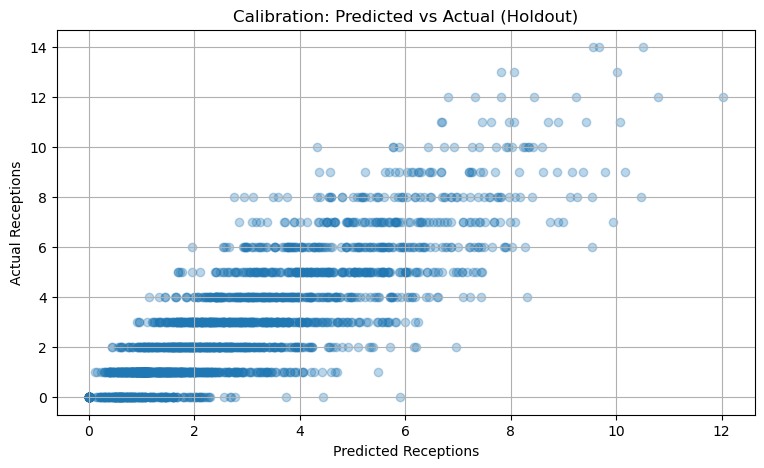

In [16]:

last_train_season = END_SEASON
train_mask = wr_weekly['season'] < last_train_season
test_mask  = wr_weekly['season'] == last_train_season

X_train, y_train = X[train_mask], y[train_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

final_model = rf_model
final_model.fit(X_train, y_train)
test_pred = final_model.predict(X_test)

print("Holdout Performance on last season:")
print("MAE:", mean_absolute_error(y_test, test_pred))
print("RMSE:", mean_squared_error(y_test, test_pred, squared=False))
print("R^2:", r2_score(y_test, test_pred))

plt.figure()
plt.scatter(test_pred, y_test, alpha=0.3)
plt.xlabel("Predicted Receptions"); plt.ylabel("Actual Receptions")
plt.title("Calibration: Predicted vs Actual (Holdout)")
plt.show()


## 6. Weekly Projection Workflow (Regular Season Only)

In [18]:

PROJ_SEASON = END_SEASON

st_col = None
for cand in ['season_type', 'game_type', 'season_type_abbr', 'gameday_type']:
    if cand in wr_weekly.columns: st_col = cand; break

if st_col:
    reg_mask = (wr_weekly['season'] == PROJ_SEASON) & (wr_weekly[st_col].astype(str).str.upper().isin(['REG','REGULAR']))
    PROJ_WEEK = int(wr_weekly.loc[reg_mask, 'week'].max()) if reg_mask.any() else int(wr_weekly.loc[(wr_weekly['season']==PROJ_SEASON) & (wr_weekly['week']<=18), 'week'].max())
else:
    PROJ_WEEK = int(wr_weekly.loc[(wr_weekly['season']==PROJ_SEASON) & (wr_weekly['week']<=18), 'week'].max())

print(f"Projecting regular season -> season={PROJ_SEASON}, week={PROJ_WEEK}")

hist = wr_weekly[(wr_weekly['season']==PROJ_SEASON) & (wr_weekly['week']==PROJ_WEEK)].copy()
if hist.empty:
    print(wr_weekly.groupby('season')['week'].max().sort_index())
    raise SystemExit("Pick a season/week that exists in wr_weekly.")

missing_feats = [c for c in feature_cols if c not in hist.columns]
for c in missing_feats: hist[c] = np.nan

proj_X = hist[feature_cols].copy().fillna(X.median(numeric_only=True))
hist['proj_receptions'] = final_model.predict(proj_X)

if 'player_name' not in hist.columns and 'name' in hist.columns:
    hist['player_name'] = hist['name']
if 'team' not in hist.columns:
    hist['team'] = (hist.get('recent_team').fillna(hist.get('team_abbr')).fillna(np.nan))

display_cols = [c for c in ['player_name','team','season','week','proj_receptions','receptions_l3','targets_l3','spread_line','total_line'] if c in hist.columns]
projections = hist[display_cols].sort_values('proj_receptions', ascending=False).reset_index(drop=True)
print(f"projections rows: {len(projections)}")
projections.head(20)


Projecting regular season -> season=2024, week=18
projections rows: 120


,player_name,team,season,week,proj_receptions,receptions_l3,targets_l3,spread_line,total_line
0,T.Higgins,CIN,2024,18,8.3150,7.666667,9.333333,-2.5,48.5
1,D.London,ATL,2024,18,8.2350,7.333333,13.000000,7.5,48.5
2,J.Chase,CIN,2024,18,8.0225,8.333333,12.333333,-2.5,48.5
3,A.St. Brown,DET,2024,18,8.0225,6.666667,8.333333,3.0,56.5
4,Q.Johnston,LAC,2024,18,7.8100,7.000000,9.333333,-7.0,42.5
5,W.Robinson,NYG,2024,18,7.7250,7.333333,9.666667,3.0,36.5
6,M.Nabers,NYG,2024,18,7.3450,6.333333,10.000000,3.0,36.5
7,L.McConkey,LAC,2024,18,7.0025,6.333333,8.000000,-7.0,42.5
8,J.Jennings,SF,2024,18,6.8700,6.000000,8.666667,4.5,42.5
9,B.Thomas,JAX,2024,18,6.6075,7.666667,11.333333,3.5,45.5


## 7. Compare to Market (PrizePicks-style)

### 7.A Fetch PrizePicks Market Data (WR Receptions)

In [21]:


import os, time, random, requests, pandas as pd
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

def _session_with_retries(total=5, backoff_factor=1.0,
                          status_forcelist=(429,500,502,503,504),
                          allowed_methods=frozenset(["GET"])):
    retry = Retry(total=total, connect=total, read=total, status=total,
                  backoff_factor=backoff_factor,
                  status_forcelist=status_forcelist,
                  allowed_methods=allowed_methods,
                  raise_on_status=False, respect_retry_after_header=True)
    sess = requests.Session()
    adapter = HTTPAdapter(max_retries=retry)
    sess.mount("https://", adapter); sess.mount("http://", adapter)
    return sess

def fetch_prizepicks_wr_receptions(out_path="data/market_wr_receptions.csv",
                                   per_page=250, max_pages=6, base_pause=1.2, max_backoff=30.0):
    base = "https://api.prizepicks.com/projections"
    page = 1; rows = []
    sess = _session_with_retries()
    headers = {"Accept":"application/json","Origin":"https://www.prizepicks.com","Referer":"https://www.prizepicks.com/","User-Agent":"Mozilla/5.0"}

    def build_lookups(included):
        look = {"player_by_id": {}, "league_by_id": {}, "team_by_id": {}, "stattype_by_id": {}}
        for obj in (included or []):
            t = obj.get("type"); attrs = obj.get("attributes", {}); _id = str(obj.get("id"))
            if t in ("new_player","players","player"):
                look["player_by_id"][_id] = {
                    "name": attrs.get("name") or attrs.get("display_name"),
                    "position": attrs.get("position"),
                    "team_abbr": attrs.get("team_abbreviation") or attrs.get("team") or attrs.get("team_name"),
                }
            elif t in ("league","leagues"):
                look["league_by_id"][_id] = (attrs.get("name") or "").upper()
            elif t in ("team","teams"):
                look["team_by_id"][_id] = attrs.get("abbr") or attrs.get("name")
            elif t in ("stat_type","stat_types"):
                look["stattype_by_id"][_id] = (attrs.get("name") or attrs.get("stat_type") or "").strip().lower()
        return look

    while True:
        if page > max_pages: break
        params = {"per_page": per_page, "page": page, "single_stat": "true", "game_mode": "pickem"}
        r = sess.get(base, params=params, headers=headers, timeout=25)
        if r.status_code == 429:
            retry_after = r.headers.get("Retry-After")
            sleep_s = float(retry_after) if retry_after else min(base_pause*(2**(page-1)), max_backoff)
            print(f"429 received. Sleeping {sleep_s:.1f}s then retrying page {page}...")
            time.sleep(sleep_s)
            r = sess.get(base, params=params, headers=headers, timeout=25)
        r.raise_for_status()
        payload = r.json()

        data = payload.get("data", [])
        included = payload.get("included", [])
        look = build_lookups(included)
        if not data: break

        for item in data:
            attrs = item.get("attributes", {}); rel = item.get("relationships", {}) or {}

            league_id = rel.get("league", {}).get("data", {}).get("id") if rel.get("league") else None
            league_name = look["league_by_id"].get(str(league_id), "")
            if league_name != "NFL": continue

            stat_type_id = rel.get("stat_type", {}).get("data", {}).get("id") if rel.get("stat_type") else None
            stat_name = look["stattype_by_id"].get(str(stat_type_id), "").lower().strip()
            if stat_name != "receptions": continue  # strict

            player_rel = rel.get("new_player") or rel.get("player")
            player_id = str(player_rel.get("data", {}).get("id")) if player_rel else None
            pinfo = look["player_by_id"].get(player_id, {})
            player_name = pinfo.get("name") or attrs.get("display_name")
            position = (pinfo.get("position") or "").upper()
            if position and position != "WR": continue

            team = (pinfo.get("team_abbr") or "").upper()

            line_score = attrs.get("line_score")
            try:
                prop_line = float(line_score) if line_score is not None else None
            except Exception:
                prop_line = None
            if prop_line is None or not (0.5 <= prop_line <= 12.5):
                continue

            if player_name:
                rows.append({"player_name": player_name, "team": team, "prop_line": prop_line})

        time.sleep(base_pause + random.uniform(0, 0.5))
        if len(data) < per_page: break
        page += 1

    if not rows: raise RuntimeError("No NFL WR receptions props found (or rate-limited).")
    df = pd.DataFrame(rows).groupby(["player_name","team"], as_index=False)["prop_line"].median()
    import os
    os.makedirs("data", exist_ok=True); df.to_csv(out_path, index=False)
    return df

market_path = "data/market_wr_receptions.csv"
market_df = fetch_prizepicks_wr_receptions(out_path=market_path, per_page=250, max_pages=6, base_pause=1.2)
print(f"Saved {len(market_df)} rows -> {market_path}")
display(market_df.head(15))


429 received. Sleeping 0.0s then retrying page 4...
Saved 33 rows -> data/market_wr_receptions.csv


,player_name,team,prop_line
0,A.J. Brown,PHI,6.0
1,Calvin Austin,PIT,4.0
2,CeeDee Lamb,DAL,7.0
3,Courtland Sutton,DEN,5.5
4,D.J. Moore,CHI,5.5
5,DK Metcalf,PIT,5.0
6,Darnell Mooney,ATL,4.0
7,Davante Adams,LA,7.5
8,DeVonta Smith,PHI,4.5
9,Drake London,ATL,6.0


### 7.A.1 Market Name & Team Fixups (increase match rate)

In [23]:

market = pd.read_csv('data/market_wr_receptions.csv')

name_fixups = {
    "Amon-Ra St. Brown": "A.St.Brown",
    "DJ Moore": "D.Moore",
    "DK Metcalf": "D.Metcalf",
    "DeVonta Smith": "D.Smith",
}
market['player_name'] = market['player_name'].replace(name_fixups)

team_map = {"SEATTLE":"SEA","SEA":"SEA","LAR":"LA","RAMS":"LA","LAC":"LAC","CHARGERS":"LAC"}
market['team'] = market['team'].replace(team_map)
market.to_csv('data/market_wr_receptions.csv', index=False)
print("Applied name/team fixups -> data/market_wr_receptions.csv")


Applied name/team fixups -> data/market_wr_receptions.csv


### 7.B Load CSV and Canonical Name Merge + Audit

In [25]:

import re
import numpy as np

if 'projections' in globals() and not projections.empty:
    try:
        market = pd.read_csv('data/market_wr_receptions.csv')
    except Exception as e:
        print("Couldn't read market file:", e)
        market = pd.DataFrame(columns=['player_name','team','prop_line'])

    def strip_suffix_parts(tokens):
        suffixes = {"jr","jr.","sr","sr.","ii","iii","iv","v"}
        return [t for t in tokens if t.lower().strip(".") not in suffixes]

    def canonical_initial_last(name: str) -> str:
        if not isinstance(name, str) or not name.strip(): return ""
        s = name.strip()
        if re.match(r"^[A-Za-z]\.[A-Za-z].*$", s):
            return s.replace(" ", "")
        s = re.sub(r"[^\w\-\.\s']", " ", s)
        parts = strip_suffix_parts(s.split())
        if not parts: return ""
        first = parts[0]
        m = re.match(r"^([A-Za-z])(?:[A-Za-z]|\.)*$", first.replace(".", ""))
        initial = m.group(1).upper() if m else first[0].upper()
        last_tokens = parts[1:] if len(parts)>1 else [first]
        last = " ".join(last_tokens).strip()
        if not last: last = first
        last = re.sub(r"\s+", " ", last)
        return f"{initial}.{last}".replace(" ", "")

    def norm_team(s):
        return (pd.Series(s).astype(str).str.upper().str.strip()
                .str.replace(r"\W+", "", regex=True))

    proj = projections.copy(); mkt = market.copy()
    proj['canon_key'] = proj['player_name'].astype(str).apply(canonical_initial_last)
    mkt['canon_key']  = mkt['player_name'].astype(str).apply(canonical_initial_last)
    proj['team'] = norm_team(proj['team']); mkt['team'] = norm_team(mkt['team'])

    # strict merge (canon_key + team)
    cmp = proj.merge(mkt[['canon_key','team','prop_line']], on=['canon_key','team'], how='left')

    # name-only fallback
    name_to_line = (mkt.dropna(subset=['canon_key','prop_line'])
                      .drop_duplicates('canon_key')
                      .set_index('canon_key')['prop_line'])
    mask_na = cmp['prop_line'].isna()
    if mask_na.any():
        cmp.loc[mask_na, 'prop_line'] = cmp.loc[mask_na, 'canon_key'].map(name_to_line)

    compare = cmp.drop(columns=['canon_key']).copy()
    compare['edge'] = compare['proj_receptions'] - compare['prop_line']
    compare = compare.sort_values('edge', ascending=False).reset_index(drop=True)

    coverage = compare['prop_line'].notna().mean() if len(compare) else 0.0
    matched = int(compare['prop_line'].notna().sum()); total = int(len(compare))
    print(f"Matched props for {matched}/{total} players ({coverage:.1%})")
    display(compare.head(20))

    um = compare[compare['prop_line'].isna()][['player_name','team','proj_receptions']].head(12)
    if len(um):
        print("\nSample unmatched players:")
        display(um)
else:
    print("No projections available to compare with market.")


Matched props for 22/120 players (18.3%)


,player_name,team,season,week,proj_receptions,receptions_l3,targets_l3,spread_line,total_line,prop_line,edge
0,Q.Johnston,LAC,2024,18,7.8100,7.000000,9.333333,-7.0,42.5,4.00,3.8100
1,O.Zaccheaus,WAS,2024,18,5.3100,5.000000,7.333333,-7.0,43.5,3.00,2.3100
2,D.London,ATL,2024,18,8.2350,7.333333,13.000000,7.5,48.5,6.00,2.2350
3,J.Williams,DET,2024,18,5.5050,5.333333,7.666667,3.0,56.5,3.50,2.0050
4,M.Mims,DEN,2024,18,5.3275,5.333333,6.000000,10.5,40.5,3.50,1.8275
5,L.McConkey,LAC,2024,18,7.0025,6.333333,8.000000,-7.0,42.5,6.00,1.0025
6,K.Boutte,NE,2024,18,4.6450,5.333333,6.333333,-3.0,36.5,4.00,0.6450
7,C.Sutton,DEN,2024,18,6.0200,5.000000,7.333333,10.5,40.5,5.50,0.5200
8,M.Washington,MIA,2024,18,3.7550,3.666667,4.666667,1.5,39.5,3.50,0.2550
9,K.Allen,CHI,2024,18,4.8975,5.666667,8.000000,10.0,41.5,5.50,-0.6025



Sample unmatched players:


,player_name,team,proj_receptions
22,T.Higgins,CIN,8.3150
23,J.Chase,CIN,8.0225
24,A.St. Brown,DET,8.0225
25,W.Robinson,NYG,7.7250
26,M.Nabers,NYG,7.3450
27,J.Jennings,SF,6.8700
28,B.Thomas,JAX,6.6075
29,M.Evans,TB,6.4725
30,R.Pearsall,SF,6.3700
31,M.Pittman,IND,6.2550


## 8. Probability & EV via Normal Approximation

In [27]:

try:
    residuals = y_test - test_pred
    resid_std = float(residuals.std())
except Exception:
    resid_std = float((y - final_model.predict(X)).std())
print(f"Residual std used for normal approx: {resid_std:.3f}")

from math import erf, sqrt
def normal_over_prob(mu, line, sigma):
    if sigma <= 1e-8: return float(mu > line)
    return 0.5 * (1 - erf((line - mu) / (sigma * sqrt(2))))

def ev(p_win, payout_multiple=0.9, stake=1.0):
    return p_win * payout_multiple - (1 - p_win) * stake

if 'compare' in globals() and not compare.empty:
    compare_norm = compare.dropna(subset=['prop_line']).copy()
    compare_norm['p_over_norm'] = compare_norm.apply(lambda r: normal_over_prob(r['proj_receptions'], r['prop_line'], resid_std), axis=1)

    compare_norm['ev_over_norm_p2']   = compare_norm['p_over_norm'].apply(lambda p: ev(p, payout_multiple=2.0))
    compare_norm['ev_over_norm_flex'] = compare_norm['p_over_norm'].apply(lambda p: ev(p, payout_multiple=1.5))

    compare_norm = compare_norm.sort_values('ev_over_norm_p2', ascending=False).reset_index(drop=True)
    display(compare_norm[['player_name','team','proj_receptions','prop_line','edge','p_over_norm','ev_over_norm_p2','ev_over_norm_flex']].head(20))
else:
    print("No compare table available. Run Section 7 first.")


Residual std used for normal approx: 1.384


,player_name,team,proj_receptions,prop_line,edge,p_over_norm,ev_over_norm_p2,ev_over_norm_flex
0,Q.Johnston,LAC,7.8100,4.00,3.8100,0.997047,1.991140,1.492617
1,O.Zaccheaus,WAS,5.3100,3.00,2.3100,0.952451,1.857352,1.381127
2,D.London,ATL,8.2350,6.00,2.2350,0.946834,1.840502,1.367085
3,J.Williams,DET,5.5050,3.50,2.0050,0.926291,1.778874,1.315729
4,M.Mims,DEN,5.3275,3.50,1.8275,0.906660,1.719979,1.266649
5,L.McConkey,LAC,7.0025,6.00,1.0025,0.765577,1.296731,0.913942
6,K.Boutte,NE,4.6450,4.00,0.6450,0.679409,1.038226,0.698521
7,C.Sutton,DEN,6.0200,5.50,0.5200,0.646440,0.939320,0.616100
8,M.Washington,MIA,3.7550,3.50,0.2550,0.573092,0.719275,0.432729
9,K.Allen,CHI,4.8975,5.50,-0.6025,0.331659,-0.005024,-0.170853


### 8.5 Exports, Value Flags, and Top-10 Printouts

In [29]:

import os
os.makedirs('outputs', exist_ok=True)

if 'compare_norm' in globals():
    out_norm = compare_norm[['player_name','team','proj_receptions','prop_line','edge','p_over_norm','ev_over_norm_p2','ev_over_norm_flex']].copy()

    out_norm['value_pick_p2']   = (out_norm['ev_over_norm_p2']   > 0.15) & (out_norm['p_over_norm'] > 0.55)
    out_norm['value_pick_flex'] = (out_norm['ev_over_norm_flex'] > 0.10) & (out_norm['p_over_norm'] > 0.55)

    out_norm.to_csv('outputs/wr_receptions_norm_ev.csv', index=False)
    print("Saved Normal EV -> outputs/wr_receptions_norm_ev.csv")

    print("\nTop 10 by EV (Normal, 2-pick power):")
    display(out_norm.sort_values('ev_over_norm_p2', ascending=False).head(10))

    print("\nTop 10 by Edge (projection - line):")
    display(out_norm.sort_values('edge', ascending=False).head(10))
else:
    print("compare_norm not found yet; run Section 8 first.")


Saved Normal EV -> outputs/wr_receptions_norm_ev.csv

Top 10 by EV (Normal, 2-pick power):


,player_name,team,proj_receptions,prop_line,edge,p_over_norm,ev_over_norm_p2,ev_over_norm_flex,value_pick_p2,value_pick_flex
0,Q.Johnston,LAC,7.8100,4.0,3.8100,0.997047,1.991140,1.492617,True,True
1,O.Zaccheaus,WAS,5.3100,3.0,2.3100,0.952451,1.857352,1.381127,True,True
2,D.London,ATL,8.2350,6.0,2.2350,0.946834,1.840502,1.367085,True,True
3,J.Williams,DET,5.5050,3.5,2.0050,0.926291,1.778874,1.315729,True,True
4,M.Mims,DEN,5.3275,3.5,1.8275,0.906660,1.719979,1.266649,True,True
5,L.McConkey,LAC,7.0025,6.0,1.0025,0.765577,1.296731,0.913942,True,True
6,K.Boutte,NE,4.6450,4.0,0.6450,0.679409,1.038226,0.698521,True,True
7,C.Sutton,DEN,6.0200,5.5,0.5200,0.646440,0.939320,0.616100,True,True
8,M.Washington,MIA,3.7550,3.5,0.2550,0.573092,0.719275,0.432729,True,True
9,K.Allen,CHI,4.8975,5.5,-0.6025,0.331659,-0.005024,-0.170853,False,False



Top 10 by Edge (projection - line):


,player_name,team,proj_receptions,prop_line,edge,p_over_norm,ev_over_norm_p2,ev_over_norm_flex,value_pick_p2,value_pick_flex
0,Q.Johnston,LAC,7.8100,4.0,3.8100,0.997047,1.991140,1.492617,True,True
1,O.Zaccheaus,WAS,5.3100,3.0,2.3100,0.952451,1.857352,1.381127,True,True
2,D.London,ATL,8.2350,6.0,2.2350,0.946834,1.840502,1.367085,True,True
3,J.Williams,DET,5.5050,3.5,2.0050,0.926291,1.778874,1.315729,True,True
4,M.Mims,DEN,5.3275,3.5,1.8275,0.906660,1.719979,1.266649,True,True
5,L.McConkey,LAC,7.0025,6.0,1.0025,0.765577,1.296731,0.913942,True,True
6,K.Boutte,NE,4.6450,4.0,0.6450,0.679409,1.038226,0.698521,True,True
7,C.Sutton,DEN,6.0200,5.5,0.5200,0.646440,0.939320,0.616100,True,True
8,M.Washington,MIA,3.7550,3.5,0.2550,0.573092,0.719275,0.432729,True,True
9,K.Allen,CHI,4.8975,5.5,-0.6025,0.331659,-0.005024,-0.170853,False,False


## 9.5 Monte Carlo Simulation for Receptions O/U (Negative Binomial)

In [31]:

def negbin_rvs(mu, k, size=10000, rng=None):
    if rng is None: rng = np.random.default_rng(42)
    p = k / (k + mu)
    return rng.negative_binomial(n=k, p=p, size=size)

def method_of_moments_k(means, vars_):
    means = np.asarray(means); vars_ = np.asarray(vars_)
    mask = (vars_ > means + 1e-6) & np.isfinite(means) & np.isfinite(vars_)
    if mask.sum() < 10: return None
    k_vals = (means[mask]**2) / (vars_[mask] - means[mask])
    k_est = np.median(k_vals[np.isfinite(k_vals) & (k_vals > 0)])
    return k_est if np.isfinite(k_est) and k_est > 0 else None

def estimate_global_k_from_history(wr_weekly_df):
    df = wr_weekly_df[['player_id','receptions']].dropna().copy()
    agg = df.groupby('player_id')['receptions'].agg(['mean','var']).reset_index()
    return method_of_moments_k(agg['mean'].values, agg['var'].values)

GLOBAL_K = estimate_global_k_from_history(wr_weekly) if 'wr_weekly' in globals() else None
if GLOBAL_K is None or not np.isfinite(GLOBAL_K) or GLOBAL_K <= 0: GLOBAL_K = 1e6  # Poisson-like fallback
print(f"Estimated global dispersion k ~= {GLOBAL_K:.2f}")

def simulate_prop_prob_over(mu, line, k=None, draws=100000, seed=42):
    rng = np.random.default_rng(seed)
    if k is None: k = GLOBAL_K
    mu = max(0.01, float(mu)); k = float(max(1e-3, k))
    sims = negbin_rvs(mu, k, size=draws, rng=rng)
    p_over = float(np.mean(sims > line))
    p_under = 1.0 - p_over
    return p_over, p_under

def ev(p_win, payout_multiple=0.9, stake=1.0):
    return p_win * payout_multiple - (1 - p_win) * 1.0

if 'compare' in globals() and not compare.empty:
    compare_mc = compare.dropna(subset=['prop_line']).copy()
    compare_mc['p_over_mc'] = compare_mc.apply(lambda r: simulate_prop_prob_over(r['proj_receptions'], r['prop_line'])[0], axis=1)

    compare_mc['ev_over_mc_p2']   = compare_mc['p_over_mc'].apply(lambda p: ev(p, payout_multiple=2.0))
    compare_mc['ev_over_mc_flex'] = compare_mc['p_over_mc'].apply(lambda p: ev(p, payout_multiple=1.5))

    compare_mc = compare_mc.sort_values('ev_over_mc_p2', ascending=False).reset_index(drop=True)
    display(compare_mc[['player_name','team','proj_receptions','prop_line','edge','p_over_mc','ev_over_mc_p2','ev_over_mc_flex']].head(20))

    out_mc = compare_mc[['player_name','team','proj_receptions','prop_line','edge','p_over_mc','ev_over_mc_p2','ev_over_mc_flex']].copy()
    out_mc['value_pick_p2']   = (out_mc['ev_over_mc_p2']   > 0.15) & (out_mc['p_over_mc'] > 0.55)
    out_mc['value_pick_flex'] = (out_mc['ev_over_mc_flex'] > 0.10) & (out_mc['p_over_mc'] > 0.55)
    out_mc.to_csv('outputs/wr_receptions_mc_ev.csv', index=False)
    print("Saved MC EV -> outputs/wr_receptions_mc_ev.csv")

    print("\nTop 10 by EV (MC, 2-pick power):")
    display(out_mc.sort_values('ev_over_mc_p2', ascending=False).head(10))
else:
    print("No compare table available. Run Section 7 first to build `compare`.")


Estimated global dispersion k ~= 6.49


,player_name,team,proj_receptions,prop_line,edge,p_over_mc,ev_over_mc_p2,ev_over_mc_flex
0,Q.Johnston,LAC,7.8100,4.00,3.8100,0.77666,1.32998,0.941650
1,J.Williams,DET,5.5050,3.50,2.0050,0.70805,1.12415,0.770125
2,M.Mims,DEN,5.3275,3.50,1.8275,0.68967,1.06901,0.724175
3,O.Zaccheaus,WAS,5.3100,3.00,2.3100,0.68764,1.06292,0.719100
4,D.London,ATL,8.2350,6.00,2.2350,0.61056,0.83168,0.526400
5,C.Sutton,DEN,6.0200,5.50,0.5200,0.50716,0.52148,0.267900
6,L.McConkey,LAC,7.0025,6.00,1.0025,0.49665,0.48995,0.241625
7,M.Washington,MIA,3.7550,3.50,0.2550,0.48063,0.44189,0.201575
8,K.Boutte,NE,4.6450,4.00,0.6450,0.46113,0.38339,0.152825
9,K.Allen,CHI,4.8975,5.50,-0.6025,0.36441,0.09323,-0.088975


Saved MC EV -> outputs/wr_receptions_mc_ev.csv

Top 10 by EV (MC, 2-pick power):


,player_name,team,proj_receptions,prop_line,edge,p_over_mc,ev_over_mc_p2,ev_over_mc_flex,value_pick_p2,value_pick_flex
0,Q.Johnston,LAC,7.8100,4.0,3.8100,0.77666,1.32998,0.941650,True,True
1,J.Williams,DET,5.5050,3.5,2.0050,0.70805,1.12415,0.770125,True,True
2,M.Mims,DEN,5.3275,3.5,1.8275,0.68967,1.06901,0.724175,True,True
3,O.Zaccheaus,WAS,5.3100,3.0,2.3100,0.68764,1.06292,0.719100,True,True
4,D.London,ATL,8.2350,6.0,2.2350,0.61056,0.83168,0.526400,True,True
5,C.Sutton,DEN,6.0200,5.5,0.5200,0.50716,0.52148,0.267900,False,False
6,L.McConkey,LAC,7.0025,6.0,1.0025,0.49665,0.48995,0.241625,False,False
7,M.Washington,MIA,3.7550,3.5,0.2550,0.48063,0.44189,0.201575,False,False
8,K.Boutte,NE,4.6450,4.0,0.6450,0.46113,0.38339,0.152825,False,False
9,K.Allen,CHI,4.8975,5.5,-0.6025,0.36441,0.09323,-0.088975,False,False
